In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

warnings.filterwarnings('ignore')

data = pd.read_csv(r'data\owid-covid-data.csv')

mae = pd.read_excel(r'data\建模結果比較.xlsx', sheet_name='MAE')
maemean = pd.read_excel(r'data\建模結果比較.xlsx', sheet_name='MAEMEAN')
rmse = pd.read_excel(r'data\建模結果比較.xlsx', sheet_name='RMSE')
# mape = pd.read_excel(r'data\建模結果比較.xlsx', sheet_name='MAPE')
ppe_value = pd.read_excel(r'data\建模結果比較.xlsx', sheet_name='PPE(Value)')
ppe_time = pd.read_excel(r'data\建模結果比較.xlsx', sheet_name='PPE(Time)')

In [6]:
mae.head()

,地區,ARIMA,LSTM,SIR
0,ARG,1407.13,4233.30,2820.215
1,MEX,1081.69,1766.03,1423.860
2,THA,253.22,756.63,504.925
3,TWN,6.89,2.42,4.655
4,CHN,29.94,17.62,23.780


In [2]:
def process_error_metrics(data, error_df, value_column, metric_name):
    # Step 1: 計算波動性
    regions = error_df['地區'].tolist()
    volatility_df = calculate_volatility(data, regions, value_column)

    # Step 2: 合併波動性和誤差指標
    merged_data = merge_data(error_df, volatility_df)

    # Step 3: 計算相關性和繪圖
    analyze_and_plot(
        data=merged_data,
        x_column='CV',  # 變異係數
        y_columns=['ARIMA', 'LSTM', 'SIR'],  # 模型指標列
        title_prefix=metric_name
    )

    return merged_data

def calculate_volatility(data, regions, value_column):
    """ 計算每個地區的波動性（標準差、均值和變異係數 CV。"""
    results = []
    for region in regions:
        region_data = data[data['iso_code'] == region]
        std_dev = region_data[value_column].std()
        mean = region_data[value_column].mean()
        cv = std_dev / mean if mean != 0 else np.nan
        results.append({'Region': region, 'std_dev': std_dev, 'mean': mean, 'CV': cv})
    return pd.DataFrame(results)

def merge_data(error_df, volatility_df):
    """ 合併誤差指標表和波動性表。 """
    return pd.merge(error_df, volatility_df, left_on='地區', right_on='Region')

def analyze_and_plot(data, x_column, y_columns, title_prefix):
    """ 計算相關性並繪製散佈圖與回歸線。 """
    correlations = {col: pearsonr(data[x_column], data[col])[0] for col in y_columns}

    fig, axes = plt.subplots(1, len(y_columns), figsize=(15, 5), sharey=True)
    for i, col in enumerate(y_columns):
        X = data[x_column].values.reshape(-1, 1)
        y = data[col].values

        # 線性回歸
        model = LinearRegression()
        model.fit(X, y)
        y_pred = model.predict(X)
        r2 = r2_score(y, y_pred)

        # 繪圖
        axes[i].scatter(X, y, color='royalblue', label='Data Points')
        axes[i].plot(X, y_pred, color='red', linestyle='--', label=f'Regression Line (R² = {r2:.2f})')
        axes[i].set_title(f'CV vs. {title_prefix} in {col}')
        axes[i].set_xlabel(f'{x_column} (Pearson r = {correlations[col]:.2f})')
        axes[i].set_ylabel(f"{title_prefix} in {col}")
        axes[i].legend()
        axes[i].grid(True)

    plt.tight_layout()
    plt.show()

------------------------- MAE -------------------------


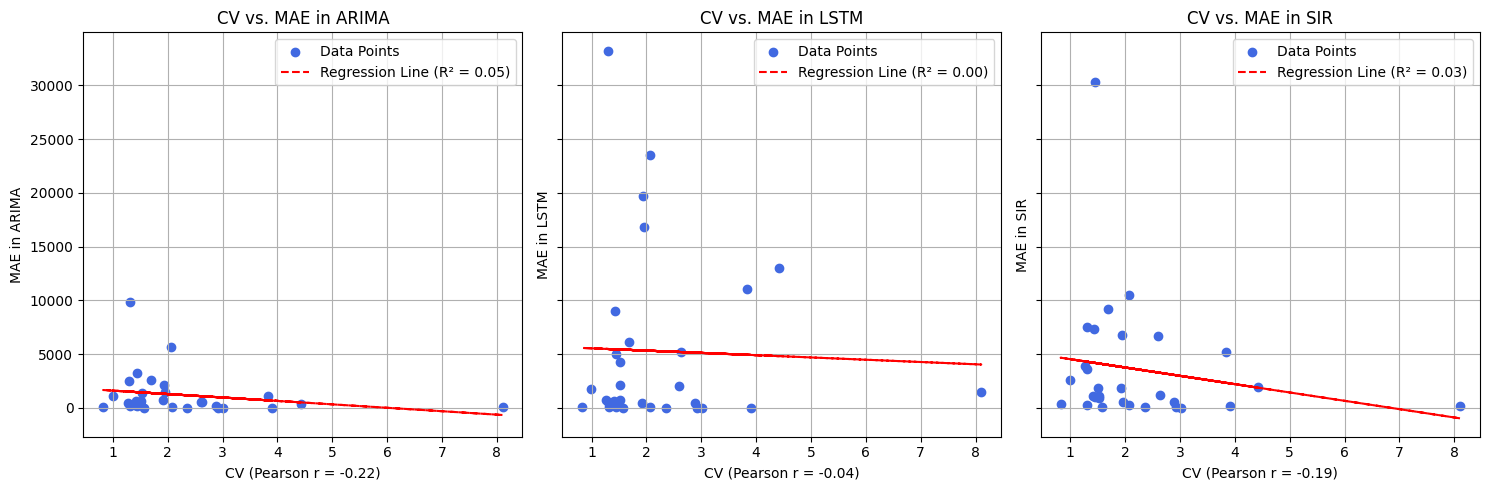

------------------------- MAEMEAN -------------------------


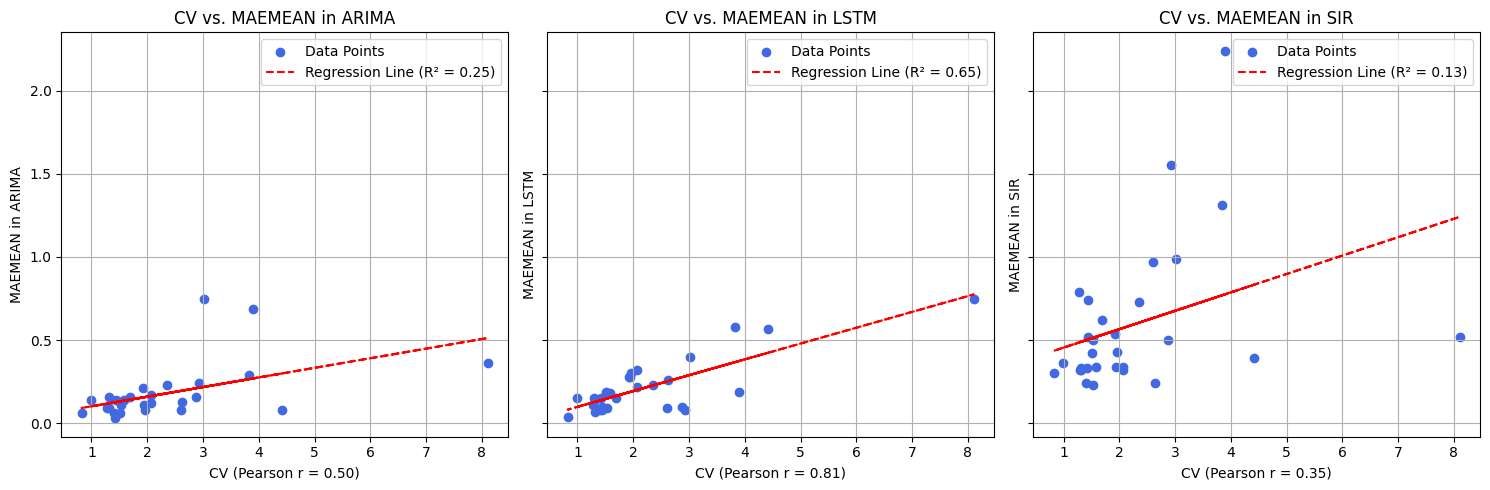

------------------------- RMSE -------------------------


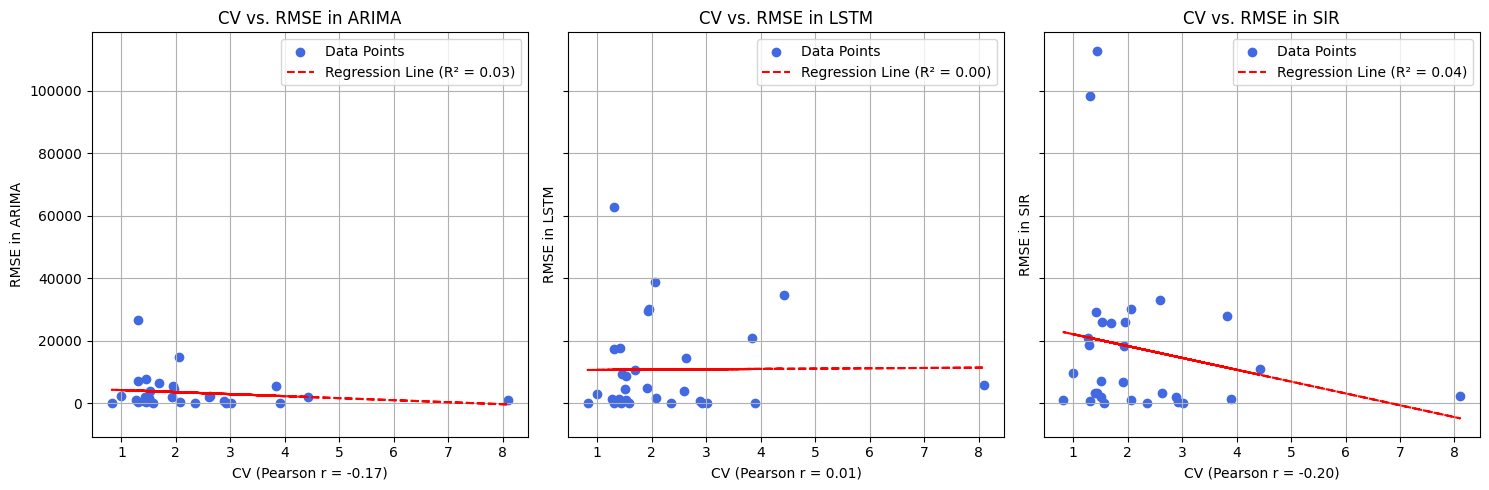

------------------------- PPE_VALUE -------------------------


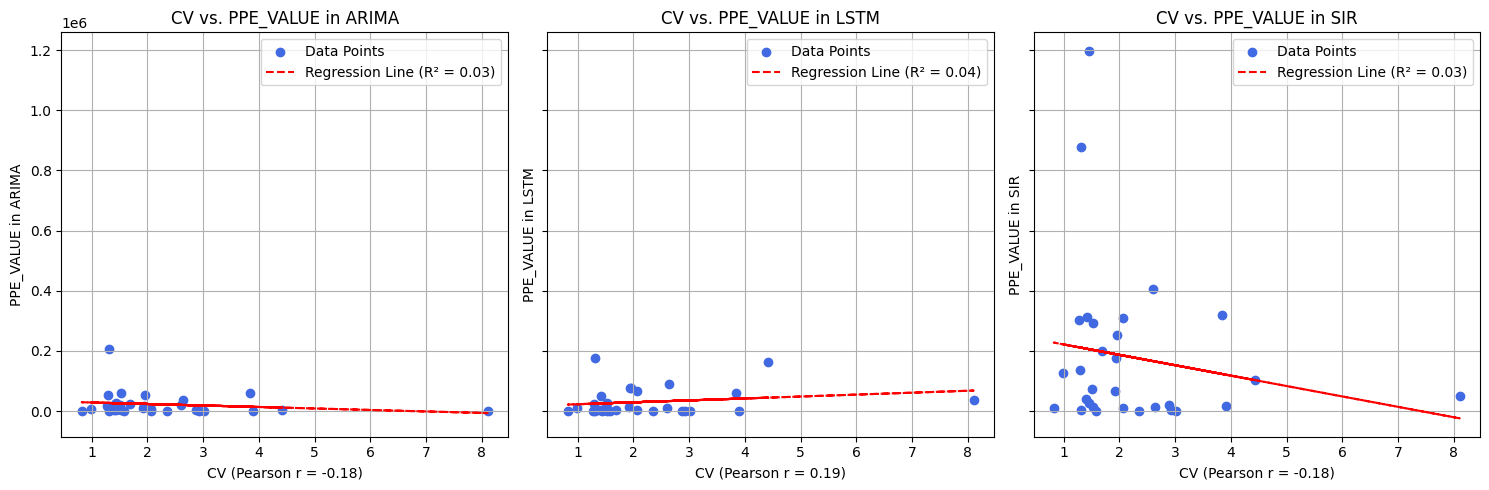

------------------------- PPE_TIME -------------------------


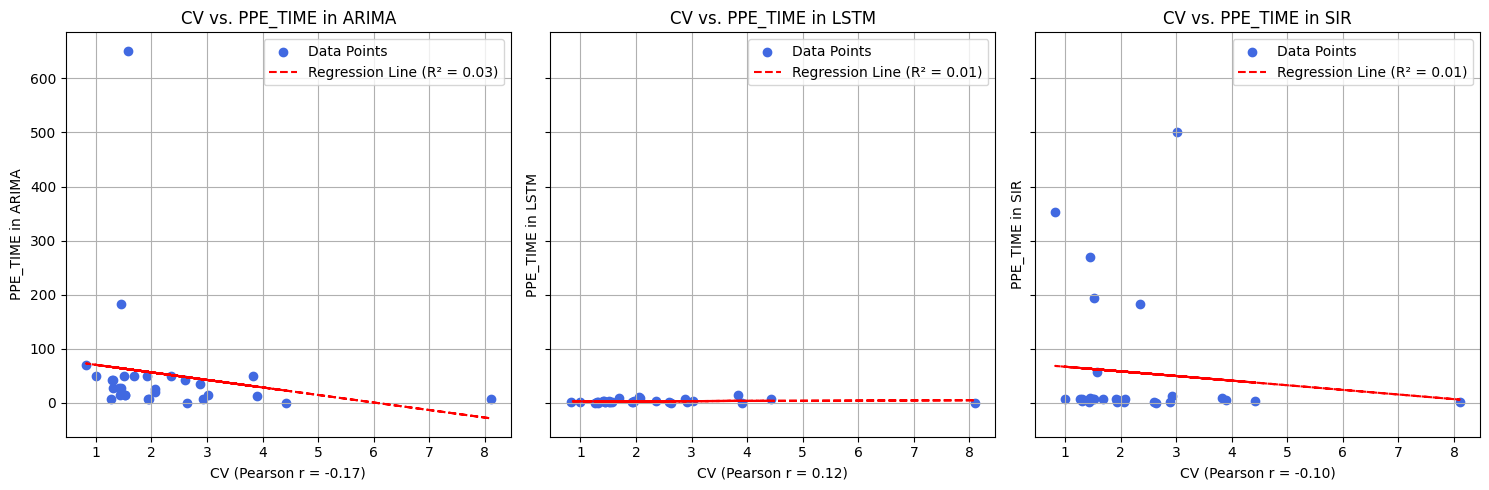

In [3]:
for i in ["mae", "maemean", "rmse", "ppe_value", "ppe_time"]:
    print("-------------------------", i.upper(), "-------------------------")
    process_error_metrics(
        data=data,
        error_df=eval(i),
        value_column='new_cases_smoothed',
        metric_name=i.upper()
    )